In [1]:
!pip install netCDF4
import numpy as np
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture
from sklearn.linear_model import LinearRegression

import netCDF4
from netCDF4 import Dataset
import pathlib


import numpy as np
import pandas as pd
import seaborn as sns

#import tensorflow as tf

#from tensorflow import keras
#from tensorflow.keras import layers

#import tensorflow_docs as tfdocs
#import tensorflow_docs.plots
#import tensorflow_docs.modeling
import xarray as xr

import torch
import torch.nn as nn
import torch.nn.functional as f

from datetime import date
import datetime

     |████████████████████████████████| 4.1MB 2.9MB/s 
     |████████████████████████████████| 317kB 33.1MB/s 


In [0]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from time import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import make_pipeline

from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor

from torch.autograd import Variable

# Functions

#ResNet implementation


In [0]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3,
                    stride=stride, padding=1, bias=False)


# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(1, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[0], 2)
        self.layer3 = self.make_layer(block, 64, layers[1], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out



In [4]:

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Select the Aghulas region in the dataset (2004 period)



In [5]:
ds = xr.open_dataset("/content/gdrive/My Drive/dataset/SST_SSH_U_V_SLA_global_2004.nc")
print(ds.sizes)
ds_cut = ds.isel(lon=slice(5,65),lat=slice(30,48))#, time=slice(1,12))
#ds_cut = ds.isel(time=0)
ds_cut

Frozen(SortedKeysDict({'lon': 1440, 'lat': 720, 'time': 366}))


<xarray.Dataset>
Dimensions:  (lat: 18, lon: 60, time: 366)
Coordinates:
  * lon      (lon) float32 -178.625 -178.375 -178.125 ... -164.125 -163.875
  * lat      (lat) float32 -82.375 -82.125 -81.875 ... -78.625 -78.375 -78.125
  * time     (time) datetime64[ns] 2004-01-01T12:00:00 ... 1981-01-01
Data variables:
    SST      (time, lat, lon) float32 ...
    SSH      (time, lon, lat) float32 ...
    U        (time, lon, lat) float32 ...
    V        (time, lon, lat) float32 ...
    SLA      (time, lon, lat) float32 ...
Attributes:
    CDI:                    Climate Data Interface version 1.5.3 (http://code...
    Conventions:            CF-1.0
    history:                Mon Jul 21 17:26:58 2014: cdo merge SST_SSH_U_V_g...
    title:                  Analysed foundation sea surface temperature, global
    DSD_entry_id:           REMSS-L4LRfnd-GLOB-tmi_amsre_OI
    references:             none
    source_data:            TMI-REMSS,AMSRE-REMSS
    contact:                support@remss.com
    GDS_version_id:         GDS-v1.0-rev1.6
    netcdf_version_id:      3.5.0
    creation_date:          2010-08-04
    product_version:        v03
    spatial_resolution:     25 km
    start_date:             2003-12-30
    start_time:             00:00:00 UTC
    stop_date:              2004-01-03
    stop_time:              23:59:59 UTC
    southernmost_latitude:  -89.875
    northernmost_latitude:  89.875
    westernmost_longitude:  -179.875
    easternmost_longitude:  179.875
    file_quality_index:     1
    comment:                www.remss.com for more infomation on product
    CDO:                    Climate Data Operators version 1.5.3 (http://code...

# Create one row with temperature profile and patch data

Concatenate SST and SSH in a single row


In [0]:
ssh = ds['SSH'].isel()#.stack(features=('latitude','longitude'))
sst = ds['SST'].isel()#.stack(features=('latitude','longitude'))

# Reduce the size 
sst = sst[:,range(5,7),range(5,7)].stack(features=('lat','lon')) # 5X5

ssh = ssh[:,range(5,7),range(5,7)].stack(features=('lat','lon')) # 5X5


# Possibly normalise features:
#temp = (temp - np.mean(temp))/np.std(temp)  # Normalize by depth
#sla = (sla - np.mean(sla))/np.std(sla)
#sst = (sst - np.mean(sst))/np.std(sst)

# Merge:
features = np.concatenate((sst, ssh), axis=1)
features.shape

(366, 8)

In [6]:
df = ds_cut.to_dataframe()
#dfy = ssh_32.to_dataframe()
#df.dropna()
print(df['SSH'])

lat      lon       time               
-82.375  -178.625  2004-01-01 12:00:00    NaN
                   2004-01-02 12:00:00    NaN
                   2004-01-03 12:00:00    NaN
                   2004-01-04 12:00:00    NaN
                   2004-01-05 12:00:00    NaN
                                         ... 
-78.125  -163.875  1981-01-01 00:00:00    0.0
                   1981-01-01 00:00:00    0.0
                   1981-01-01 00:00:00    0.0
                   1981-01-01 00:00:00    0.0
                   1981-01-01 00:00:00    0.0
Name: SSH, Length: 395280, dtype: float32


In [0]:
for v in ds_cut.data_vars:
    print('{:>10}: {}'.format(v, ds[v].attrs['long_name']))

       SST: analysed sea surface temperature
       SSH: H
         U: U
         V: V
       SLA: H


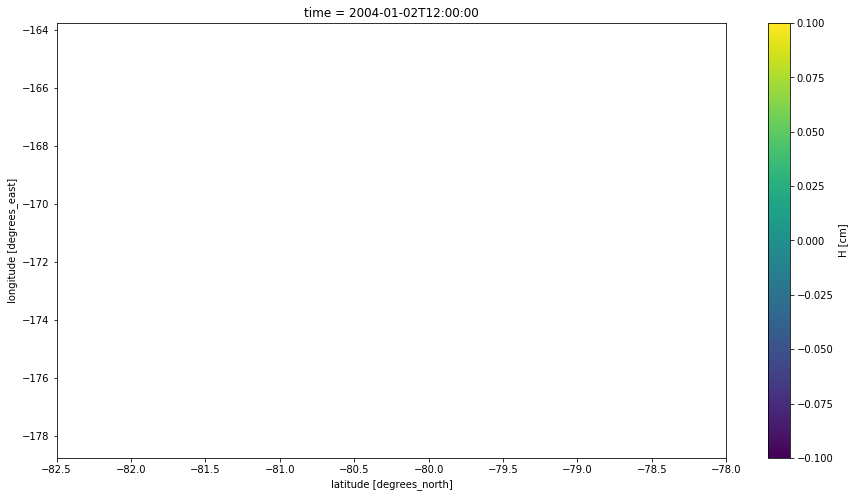

In [0]:
#sns.scatterplot(data=df['SST'].values)
plt.rcParams['figure.figsize'] = (15, 8)
ds_cut.SSH.sel(time='2001-01-01', method='nearest').plot()

## I - Remove Nan Value

In [0]:
df2 = df.fillna(df.mean())
df2.describe()

,SST,SSH,U,V,SLA
count,395280.000000,395280.0,395280.0,395280.0,395280.0
mean,272.096161,0.0,0.0,0.0,0.0
std,0.855639,0.0,0.0,0.0,0.0
min,271.350006,0.0,0.0,0.0,0.0
25%,271.350006,0.0,0.0,0.0,0.0
50%,271.350006,0.0,0.0,0.0,0.0
75%,273.149994,0.0,0.0,0.0,0.0
max,273.899994,0.0,0.0,0.0,0.0


In [0]:
df2.isnull().sum()

SST    0
SSH    0
U      0
V      0
SLA    0
dtype: int64

lat      lon       time               
-82.375  -178.625  2004-01-01 12:00:00    271.350006
                   2004-01-02 12:00:00    271.350006
                   2004-01-03 12:00:00    271.350006
                   2004-01-04 12:00:00    271.350006
                   2004-01-05 12:00:00    271.350006
                                             ...    
-78.125  -163.875  1981-01-01 00:00:00    273.149994
                   1981-01-01 00:00:00    273.149994
                   1981-01-01 00:00:00    273.149994
                   1981-01-01 00:00:00    273.149994
                   1981-01-01 00:00:00    273.149994
Name: SST, Length: 395280, dtype: float32

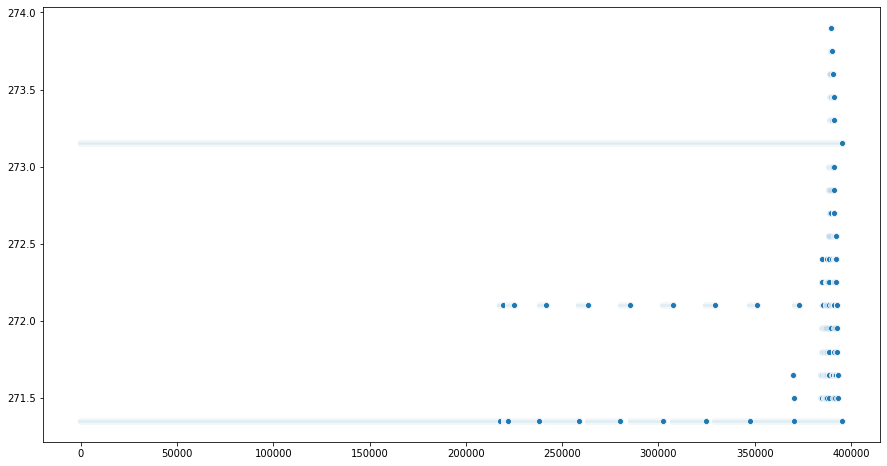

In [0]:
sns.scatterplot(data=df2['SST'].values)
df2['SST']

In [0]:
dd = df.astype('float32')

X = dd['SST'].round(2)
y = dd['SSH'].round(2)
X.describe()

count    1.237350e+07
mean     2.624807e+02
std      2.687164e+01
min      2.713500e+02
25%      2.751000e+02
50%      2.887500e+02
75%      2.983500e+02
max      3.057000e+02
Name: SST, dtype: float64

In [0]:
df.describe()

,SST,SSH,U,V,SLA
count,373566.000000,145800.0,146880.0,146880.0,146880.0
mean,272.101746,0.0,0.0,0.0,0.0
std,0.878241,0.0,0.0,0.0,0.0
min,271.350006,0.0,0.0,0.0,0.0
25%,271.350006,0.0,0.0,0.0,0.0
50%,271.350006,0.0,0.0,0.0,0.0
75%,273.149994,0.0,0.0,0.0,0.0
max,273.899994,0.0,0.0,0.0,0.0


In [0]:
X = df['SST'].astype('float32').dtypes
X.type

numpy.float32

## II - Training of the ResNet

In [0]:
X2 = df['SST'].values#.reshape(-1, 1)
y2 = df['SSH'].values#.reshape(-1, 1)
X2 = np.nan_to_num(X2)
y2 = np.nan_to_num(y2)
X = X2.astype('long')
y = y2.astype('long')

# Split the data into training/testing sets
X_train = X[:300]
X_test = X[66:]

# Split the targets into training/testing sets
y_train = y[:300]
y_test = y[66:]
"""
print("Training MLPRegressor...")
tic = time()
est = make_pipeline(QuantileTransformer(),
                    MLPRegressor(hidden_layer_sizes=(50, 50),
                                 learning_rate_init=0.01,
                                 early_stopping=True))
est.fit(X_train, y_train)
print("done in {:.3f}s".format(time() - tic))
print("Test R2 score: {:.2f}".format(est.score(X_test, y_test)))


# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)
"""
featuresTrain = torch.from_numpy(X_train)
targetsTrain = torch.from_numpy(y_train)
targetsTrain.shape

# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(X_test)
targetsTest = torch.from_numpy(y_test) # data type is long

# batch_size, epoch and iteration
batch_size = 2
n_iters = 100
num_epochs = 5

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)

# Create ResNet
net_args = {
    "block": ResidualBlock,
    "layers": [2, 2, 2, 2]
}
model = ResNet(**net_args).float()

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# Adam Optimizer
learning_rate = 0.05
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [0]:
loss_list = []
iteration_list = []
accuracy_list = []
count = 0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        train  = Variable(images.resize_(batch_size, 1, 32, 32))
        labels = Variable(labels)           
        # Clear gradients
        optimizer.zero_grad()    
        # Forward propagation
        outputs = model(train.float())        
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)        
        # Calculating gradients
        loss.backward()        
        # Update parameters
        optimizer.step()        
        count += 1      
        if count % 250 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                images = Variable(images.resize_(batch_size, 1, 32, 32))                
                # Forward propagation
                outputs = model(images.float())                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]                
                # Total number of labels
                total += labels.size(0)              
                correct += (predicted == labels).sum()         
            accuracy = 100 * correct / float(total)           
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            if count % 500 == 0:
                # Print Loss
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))


(11814, 1)
Coefficients: 
 [tensor(0.), tensor(0.), tensor(0.)]


NameError: ignored

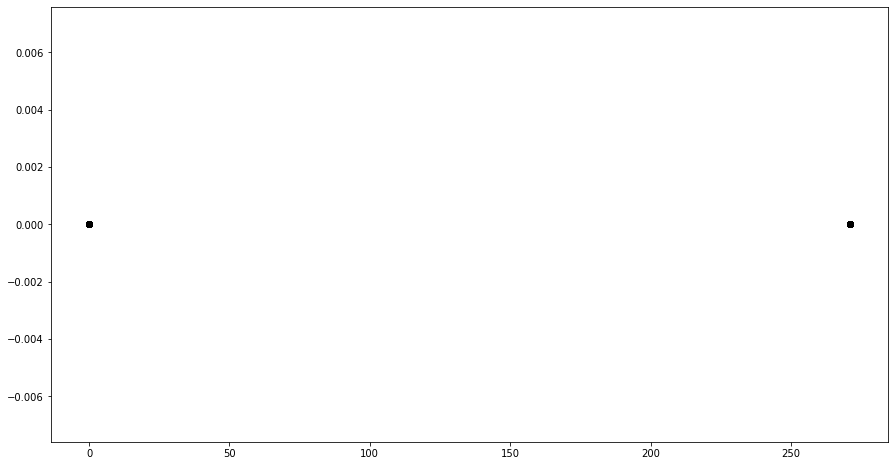

In [0]:
X_test = np.reshape(X_test,(-1,1))
print(X_test.shape)

print('Coefficients: \n', loss_list)
# The mean squared error


# Plot outputs
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [0]:
resGrid     = 0.05
resGridLR   = 1.
IterScale   = 10
IterScaleLR = np.array([100,5])
LamScale    = 0.2
latitude_min = 0
latitude_max = 30
longitude_min = -15
longitude_max = 15
RefTime = date(1900,1,1)

time = time / (60.*60.*24)
time = datetime.datetime.toordinal(RefTime) + time


indlat = np.where( (lat >= latitude_min) & (lat <= latitude_max ) )
indlon = np.where( (lon >= longitude_min) & (lon <= longitude_max ) )
sshROI  = ssh[0,indlat[0][0]:indlat[0][-1],indlon[0][0]:indlon[0][-1]].squeeze()
sstROI  = sst[0,indlat[0][0]:indlat[0][-1],indlon[0][0]:indlon[0][-1]].squeeze()
maskROI = sst.mask[0,indlat[0][0]:indlat[0][-1],indlon[0][0]:indlon[0][-1]].squeeze()

NameError: name 'time' is not defined

In [0]:
for i in range(0,2):
    sshROI  = ssh[i,indlat[0][0]:indlat[0][-1],indlon[0][0]:indlon[0][-1]].squeeze()
    sstROI  = sst[i,indlat[0][0]:indlat[0][-1],indlon[0][0]:indlon[0][-1]].squeeze()
    print("SSH : " + str(sshROI))
    print("SSH shape : " + str(sshROI.shape))

    print("SST : " + str(sstROI))
    print("SST shape : " + str(sstROI.shape))
    #maskROI = sst.mask[i,indlat[0][0]:indlat[0][-1],indlon[0][0]:indlon[0][-1]].squeeze()
    plt.figure()
    imgplot = plt.imshow(np.flipud(sstROI))
    imgplot.set_cmap('hot')

    plt.figure()
    imgplot = plt.imshow(np.flipud(sstROI))
    imgplot.set_cmap('hot')

NameError: name 'indlat' is not defined

In [0]:
sshROI  = np.ma.empty([3453, 3453])
sstROI  = np.ma.empty([3453, 3453])
for i in range(0,24):
    np.hstack((sshROI, ssh[i,indlat[0][0]:indlat[0][-1],indlon[0][0]:indlon[0][-1]].squeeze()))
    np.hstack((sstROI, sst[i,indlat[0][0]:indlat[0][-1],indlon[0][0]:indlon[0][-1]].squeeze()))
    
X_train = np.ma.getdata(sstROI)
Y_train = np.ma.getdata(sshROI)
Y_train.shape

featuresTrain = torch.from_numpy(X_train[:,:20])
targetsTrain = torch.from_numpy(Y_train[:,:20])
targetsTrain.shape

# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(Y_train[:,20:])
targetsTest = torch.from_numpy(Y_train[:,20:]) # data type is long

# batch_size, epoch and iteration
batch_size = 2
n_iters = 100
num_epochs = 5

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)

# Create ResNet
net_args = {
    "block": ResidualBlock,
    "layers": [2, 2, 2, 2]
}
model = ResNet(**net_args)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# Adam Optimizer
learning_rate = 0.05
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

NameError: name 'indlat' is not defined

In [0]:
def read_data(dataset_path,X,y):
    data = Dataset(dataset_path, "r", format="NETCDF4")
    #print(data.variables)
    station = 0
    y_var = data.variables[y][:5]
    X_var = data.variables[X][:5]
    X_flat = X_var.flatten()
    print(X_var.shape[1])
    x = np.empty(1*X_var.shape[1]*X_var.shape[2])
    for i in range(5):
        for j in range(X_var.shape[1]):
            for k in range(X_var.shape[2]):
                x = np.append(x, X_var[i][j][k])
    
    time_var = data.variables["time_counter"]
    jd = netCDF4.num2date(time_var[:1],time_var.units)
    """hs = pd.Series(X_flat[:,station],index=jd)
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(111)
    hs.plot(ax=ax,title='%s at %s' % (X_var.long_name,nc.id))
    ax.set_ylabel(h.units)"""
    

In [0]:
read_data("/home/gambrosino/WORK/DATA/NATL60-CJM165_y2012m06d14.1h_gridT.nc","sosstsst","sossheig")

FileNotFoundError: [Errno 2] No such file or directory: b'/home/gambrosino/WORK/DATA/NATL60-CJM165_y2012m06d14.1h_gridT.nc'

In [0]:
print(rootgrp.variables.keys())
ssh = rootgrp.variables["SSH"][:]
sst = rootgrp.variables["SST"][:]
time_var = rootgrp.variables["time"]
lat_var, lon_var = rootgrp.variables['lat'], rootgrp.variables['lon']
for d in rootgrp.dimensions.items():
    print(d)
lat = lat_var[:]
lon = lon_var[:]
time = time_var[:]
time

odict_keys(['lon', 'lat', 'time', 'SST', 'SSH', 'U', 'V', 'SLA'])
('lon', <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 1440)
('lat', <class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 720)
('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 366)


masked_array(data=[7.258032e+08, 7.258896e+08, 7.259760e+08, 7.260624e+08,
                   7.261488e+08, 7.262352e+08, 7.263216e+08, 7.264080e+08,
                   7.264944e+08, 7.265808e+08, 7.266672e+08, 7.267536e+08,
                   7.268400e+08, 7.269264e+08, 7.270128e+08, 7.270992e+08,
                   7.271856e+08, 7.272720e+08, 7.273584e+08, 7.274448e+08,
                   7.275312e+08, 7.276176e+08, 7.277040e+08, 7.277904e+08,
                   7.278768e+08, 7.279632e+08, 7.280496e+08, 7.281360e+08,
                   7.282224e+08, 7.283088e+08, 7.283952e+08, 7.284816e+08,
                   7.285680e+08, 7.286544e+08, 7.287408e+08, 7.288272e+08,
                   7.289136e+08, 7.290000e+08, 7.290864e+08, 7.291728e+08,
                   7.292592e+08, 7.293456e+08, 7.294320e+08, 7.295184e+08,
                   7.296048e+08, 7.296912e+08, 7.297776e+08, 7.298640e+08,
                   7.299504e+08, 7.300368e+08, 7.301232e+08, 7.302096e+08,
                   7.3029